# Простые методы предсказания ВР

Устанавливаем и импортируем все зависимости

In [41]:
%pip install sktime
%pip install aeon
%pip install pmdarima
%pip install statsmodels
%pip install prophet
%pip install sktime[all_extras]
%pip install statsforecast>=1.3.2
%pip install tbats
import aeon

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached arch-7.0.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached dash-2.17.0-py3-none-any.whl.metadata (10 kB)
  Using cached dtw_python-1.4.2-cp311-cp311-win_amd64.whl.metadata (7.7 

  error: subprocess-exited-with-error
  
  × Building wheel for pycatch22 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\pycatch22
      copying src\pycatch22\catch22.py -> build\lib.win-amd64-cpython-311\pycatch22
      copying src\pycatch22\__init__.py -> build\lib.win-amd64-cpython-311\pycatch22
      running egg_info
      writing src\pycatch22.egg-info\PKG-INFO
      writing dependency_links to src\pycatch22.egg-info\dependency_links.txt
      writing top-level names to src\pycatch22.egg-info\top_level.txt
      reading manifest file 'src\pycatch22.egg-info\SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      adding license file 'LICENSE'
      writing manifest file 'src\pycatch22.egg-info\SOURCES.txt'
      copying src\pycatch22\.DS_Store -> build\

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
Using cached tbats-1.1.3-py3-none-any.whl (44 kB)


In [21]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", FutureWarning)

import sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose import  TransformedTargetForecaster, AutoEnsembleForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster, TrendForecaster, STLForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats  import BATS
from sktime.forecasting.ets   import AutoETS

from sktime.forecasting.statsforecast import (StatsForecastAutoETS, 
                                              StatsForecastAutoTheta,
                                              StatsForecastAutoCES,
                                              StatsForecastMSTL)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

from sktime.utils.plotting import plot_series
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

В качестве набора данных давайте набор данных о климате.

In [22]:
path_ts1 = 'DailyDelhiClimateTrain.csv'
path_ts2 = 'DailyDelhiClimateTest.csv'
df1 = pd.read_csv(path_ts1, parse_dates=['date'], index_col="date")
df2 = pd.read_csv(path_ts2, parse_dates=['date'], index_col="date")
df = pd.concat([df1, df2])
df_unique = df[~df.index.duplicated()].copy() 
# df = pd.read_csv(path_ts)
# df=df.fillna(df.mean())
df = df_unique
df.tail(116)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


Для анализа выберем столбец средней температуры - meantemp? затем перегруппируем данные

In [23]:
y = df.meantemp.asfreq('7d')
y.head()

date
2013-01-01    10.000000
2013-01-08     8.857143
2013-01-15    14.714286
2013-01-22     9.500000
2013-01-29    14.125000
Freq: 7D, Name: meantemp, dtype: float64

Визуализируем результат

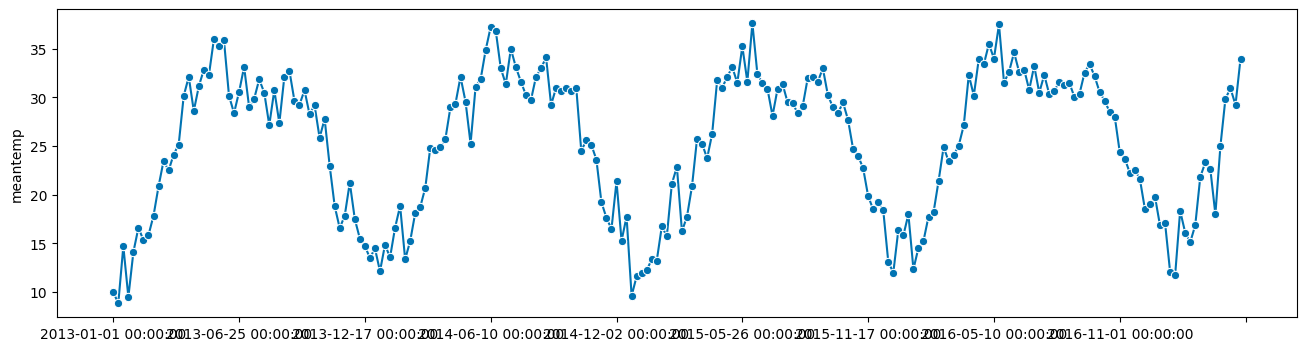

In [24]:
plot_series(y);

Check splitted data size: Train: 158, Test: 67


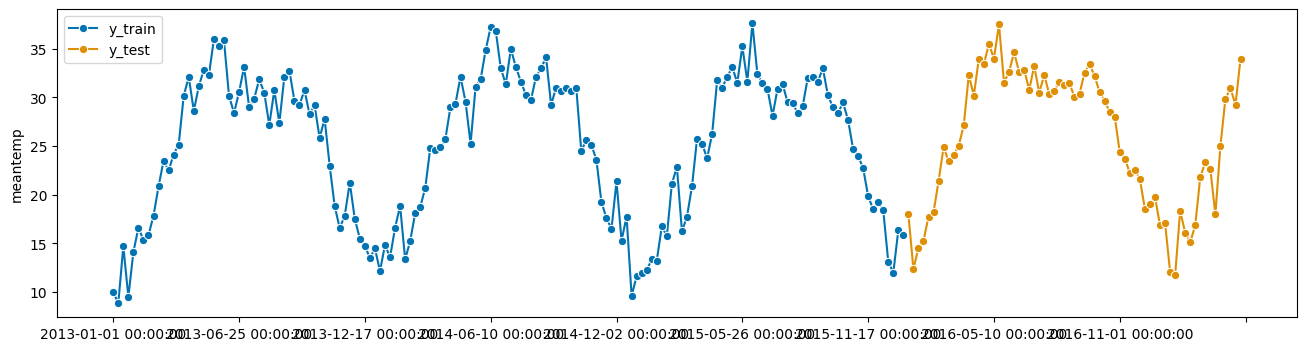

In [25]:
TEST_SIZE = int(0.3*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

В силу меньшего числа сезонов, делить на выборки будем в соотношении 0.7/0.3

## Наивные методы предсказания

sMAPE = 0.463


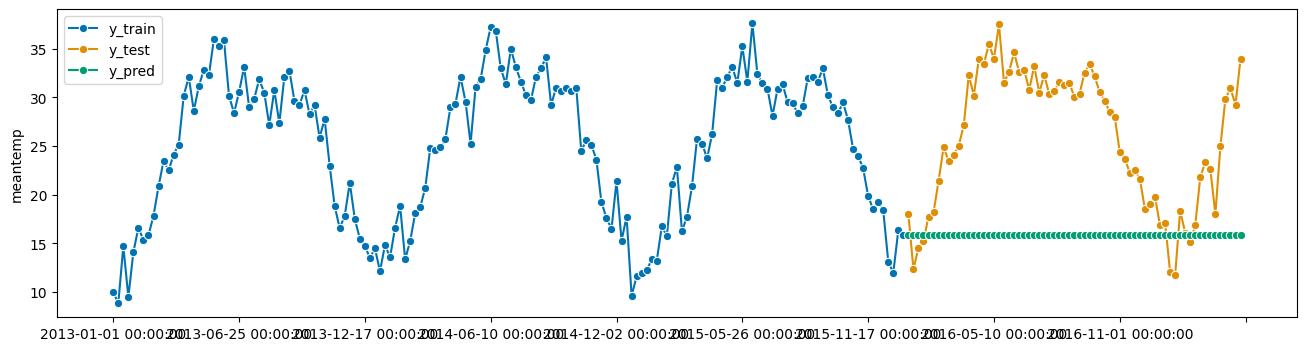

In [26]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Катастрофичный результат

sMAPE = 0.106


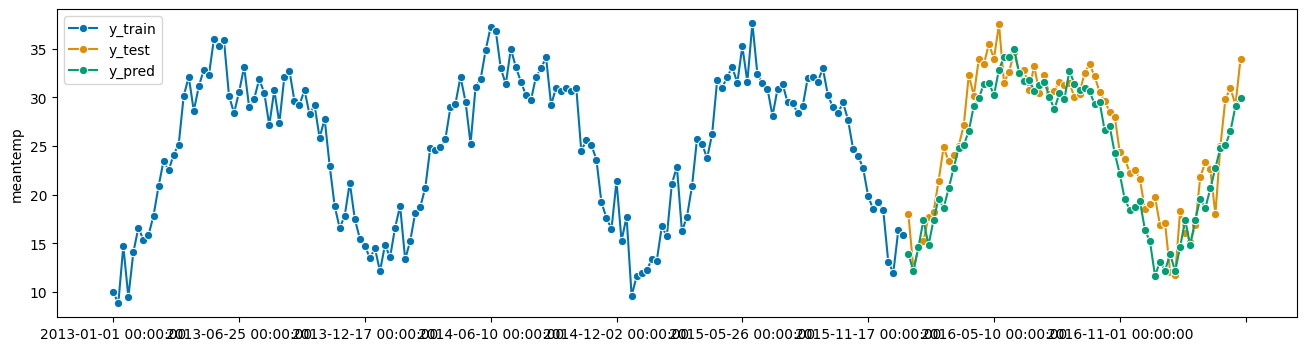

In [27]:
SEASON = 52

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Симметричная средняя процентная ошибка снизилась до приемлимых 0.106 (спойлер - принципиально лучше она уже не будет)

sMAPE = 0.465


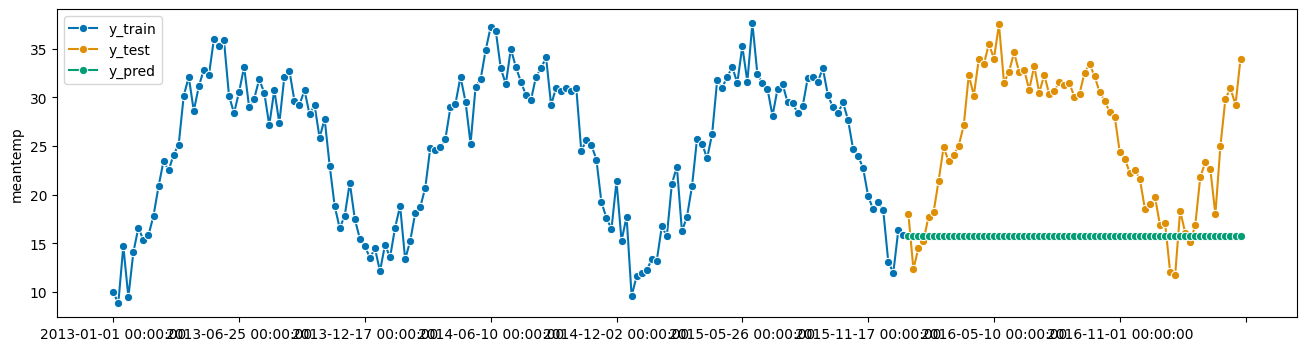

In [28]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.095


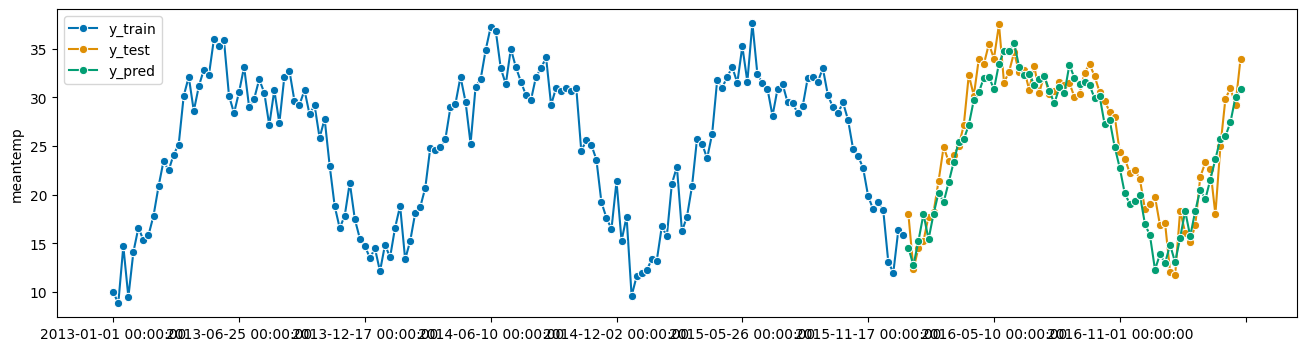

In [29]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)



forecaster = holt_winter

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')


sMAPE = 0.093


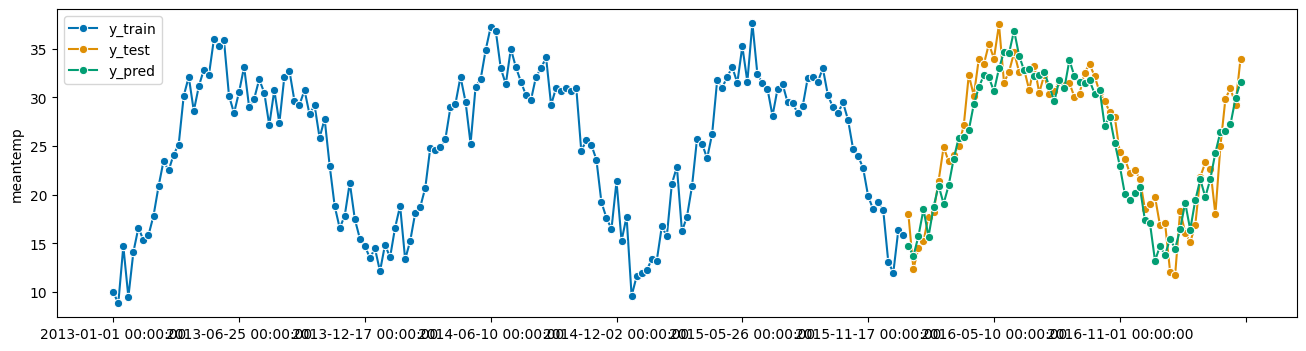

In [30]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = AutoEnsembleForecaster(
    [
#         ("ses", ses),
#         ("holt", holt),
#         ("damped", damped_holt),
        ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
#         ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
#         ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)        
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]); 



Лучший результат - ансамблированные методы, sMAPE = 0.093

sMAPE = 0.106


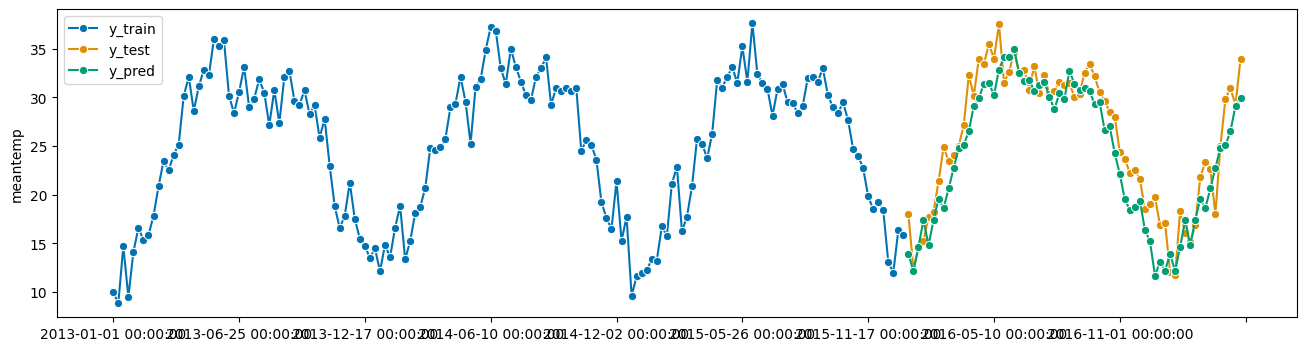

In [31]:
forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.105


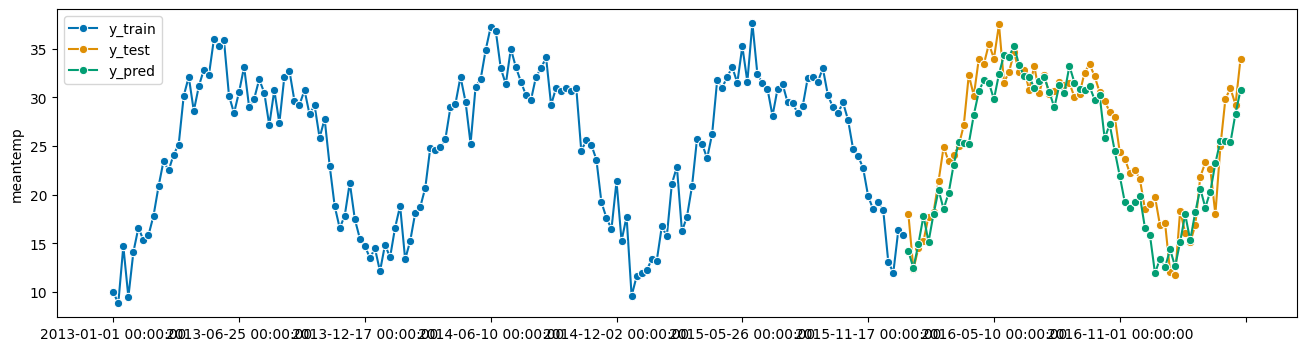

In [32]:
forecaster = StatsForecastAutoETS(season_length = 52,
                                  model = 'ZZA',
                                  damped = True,)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

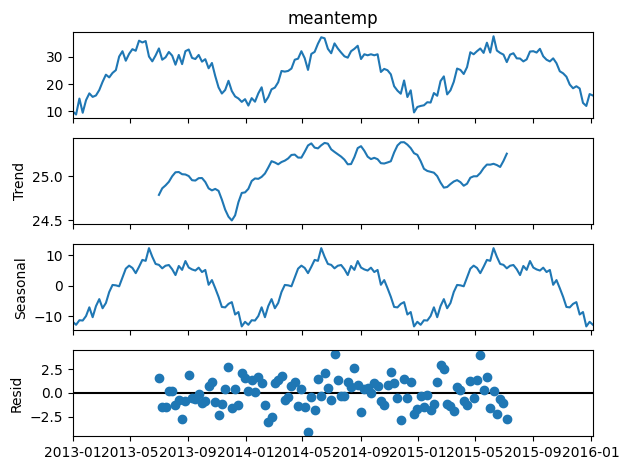

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 52)
result.plot();

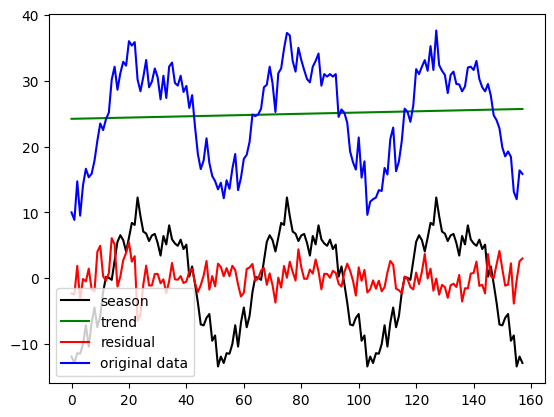

In [34]:
deseason = Deseasonalizer(model="additive", sp=52) #Remove seasonal components from a time series.
detrend  = Detrender(forecaster=TrendForecaster())

season   = y_train.values.squeeze() - deseason.fit_transform(y_train.values).squeeze()
trend    = y_train.values.squeeze() - detrend.fit_transform(y_train.values).squeeze()
residual = y_train.values.squeeze() - trend - season

plt.plot(season, c='k', label='season')
plt.plot(trend, c='g', label='trend')
plt.plot(residual, c='r', label='residual')
plt.plot(y_train.values, c='b', label='original data')
plt.legend()
plt.show()

sMAPE = 0.108


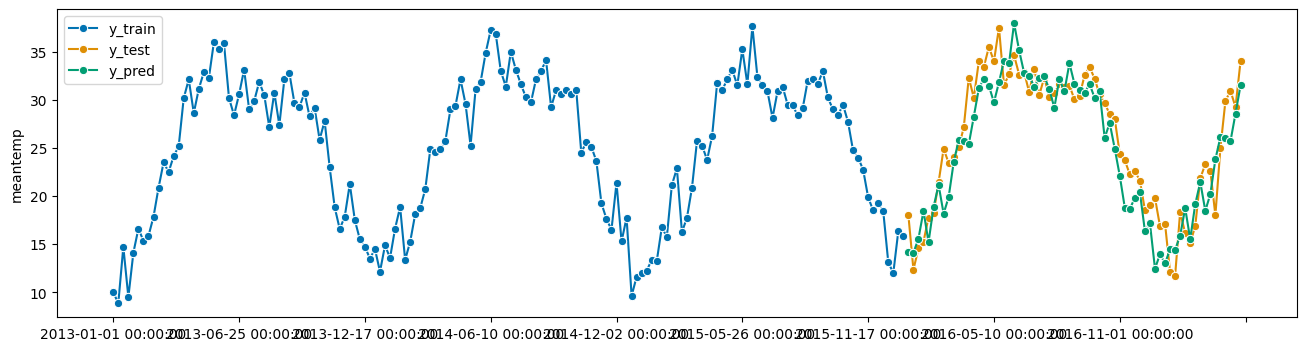

In [35]:
SEASON = 52

fh = ForecastingHorizon(y_test.index, is_relative=False)

# объек предсказатель
ses         = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="additive", sp=SEASON)),
                ("detrend", Detrender(forecaster=TrendForecaster())),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.106


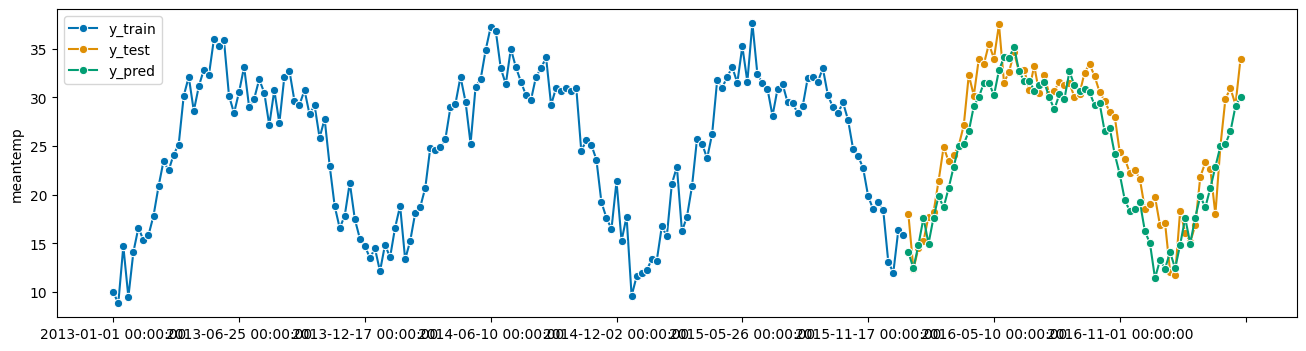

In [36]:
forecaster = StatsForecastMSTL(season_length=52,)  
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.108


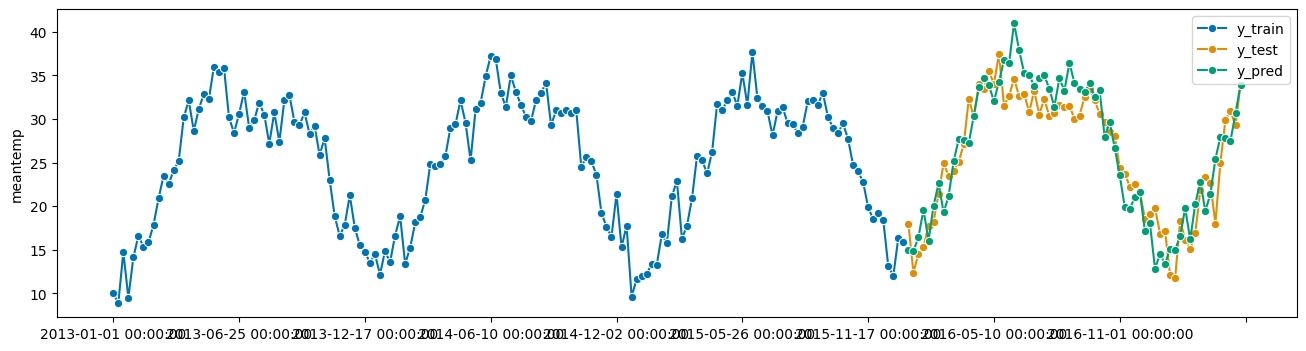

In [37]:
forecaster = ThetaForecaster(sp=SEASON)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.468


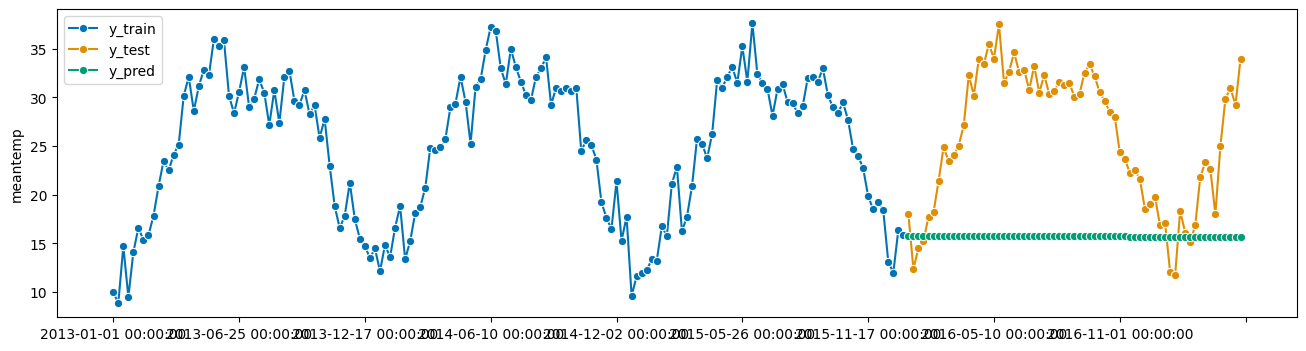

In [38]:
forecaster = StatsForecastAutoTheta(season_length = 52,
                                    decomposition_type = 'additive',
                                    model = None,)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.101


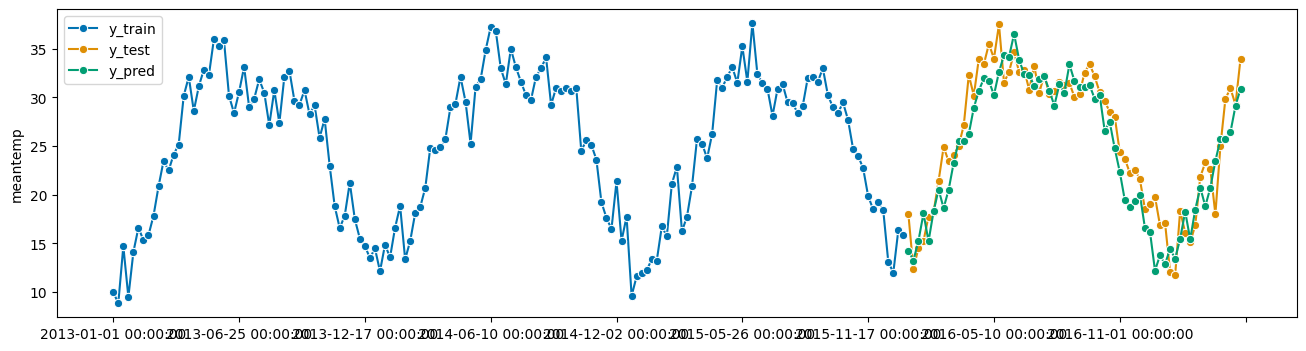

In [39]:
forecaster =  StatsForecastAutoCES(season_length = 52)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.098


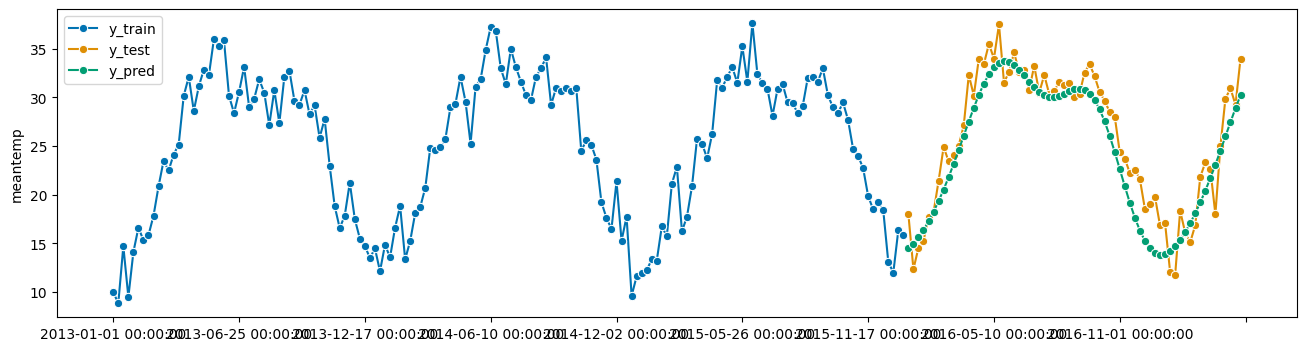

In [42]:
forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=[SEASON],
    use_arma_errors=True,
    n_jobs=-1)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

22:55:31 - cmdstanpy - INFO - Chain [1] start processing
22:55:31 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.094


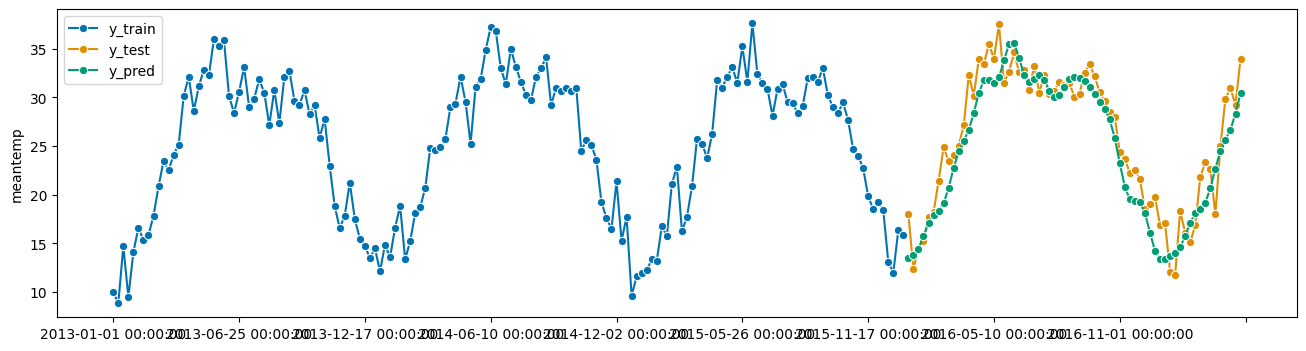

In [43]:
forecaster = Prophet(seasonality_mode='additive',
                     n_changepoints=int(len(y_train) / 4),
                     add_country_holidays={'country_name': 'Germany'},
                     yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

TBATS и Prophet, несмотря на внушительное время обучения, результаты показали слабые, как визуально, так и по метрике sMAPE. Лучшим методом можно смело признать ансамблевое объединение методов экспоненциального сглаживания